 Mohammad Sarfaraz Gundluru

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install pyspark

In [ ]:
from pyspark.sql.types import StructType, StructField, StringType, IntegerType
import re

In [ ]:
from pyspark.sql import SparkSession

# Create a SparkSession
spark = SparkSession.builder.appName("LogAnalysis").getOrCreate()

# Path to your log file in Google Drive
log_file = "/content/drive/My Drive/web.log"

# Read the log file as text
log_rdd = spark.sparkContext.textFile(log_file)

# student 1: Mohammad Sarfaraz Gundluru - 2702684

# Task 1

In [ ]:
#This code processes a log file using Apache Spark to extract key details such as IP addresses, HTTP methods, and URLs from each log entry. It applies a regex pattern to identify and extract these components, filtering out any invalid or malformed entries. Finally, it displays the first 10 extracted log records in a structured format.

from pyspark.sql import SparkSession
import re

# Initialize Spark Session
spark = SparkSession.builder.appName("LogParser").getOrCreate()

# Load log file
log_data = log_rdd

def extract_log_details(log_entry):
    """
    Funcion to extract IP addr, HTTP methods, and URL from a logentry.
    """
    try:
        pattern = r'(\d+\.\d+\.\d+\.\d+) - - \[.*?\] "(GET|POST|PUT|DELETE|HEAD|OPTIONS) (.*?) HTTP/.*?"'
        extracted_info = re.search(pattern, log_entry)
        if extracted_info:
            ip_address = extracted_info.group(1)
            request_method = extracted_info.group(2)
            request_url = extracted_info.group(3)
            return ip_address, request_method, request_url
    except Exception as error:
        return None

# Transform RDD with extracted information
processed_logs = log_data.map(extract_log_details).filter(lambda entry: entry is not None)

# Display sample extracted records
print("Extracted Log_Details:")
print("IP_Address\tMethods\tURL")
for log in processed_logs.take(10):
    print(f"{log[0]}\t{log[1]}\t{log[2]}")


Extracted Log_Details:
IP_Address	Methods	URL
88.211.105.115	POST	/history/missions/
231.70.64.145	PUT	/web-development/countdown/
219.42.234.172	POST	/networking/technology/
183.173.185.94	GET	/security/firewall/
164.12.8.113	GET	/web-development/technology/
110.98.7.240	PUT	/history/apollo/
123.31.25.147	GET	/data-analysis/missions/
220.182.78.75	GET	/history/launch/
206.186.128.82	GET	/security/apollo-11/
12.33.251.59	GET	/web-development/data/


In [ ]:
from pyspark.sql.functions import col, to_timestamp

# Convert RDD to DataFrame with renamed_columns
log_dataframe = processed_logs.toDF(["Client_IP", "Request_Method", "Requested_URL"])

# Register the DataFrame as a temporary view for SQL queries
log_dataframe.createOrReplaceTempView("web_logs")

# Create a temporary view for performing SQL-based operations
log_dataframe.createOrReplaceTempView("parsed_web_logs")


In [ ]:
from pyspark.sql.functions import col, count, expr

# This code defines a SQL query to analyze web server logs, calculating request summaries, method usage, and URL classifications. It then joins these summaries to produce a detailed view, ordering by request counts, method counts, and URL hits. Finally, it executes the query using Spark SQL, caches the result, and displays the top 20 rows.
log_dataframe.createOrReplaceTempView("server_logs")

# Optimized SQL query with limited computation
optimized_sql = """
WITH RequestSummary AS (
    SELECT Client_IP, COUNT(*) AS TotalRequests
    FROM server_logs
    GROUP BY Client_IP
),
MethodSummary AS (
    SELECT Request_Method, COUNT(*) AS TotalMethods
    FROM server_logs
    GROUP BY Request_Method
),
URLClassification AS (
    SELECT DISTINCT Requested_URL,
        CASE
            WHEN Requested_URL LIKE '%/history/%' THEN 'History'
            WHEN Requested_URL LIKE '%/web-development/%' THEN 'Web Development'
            WHEN Requested_URL LIKE '%/networking/%' THEN 'Networking'
            WHEN Requested_URL LIKE '%/security/%' THEN 'Security'
            WHEN Requested_URL LIKE '%/data-analysis/%' THEN 'Data Analysis'
            ELSE 'Other'
        END AS URL_Type
    FROM server_logs
),
URLSummary AS (
    SELECT URL_Type, COUNT(*) AS URL_Hits
    FROM URLClassification
    GROUP BY URL_Type
)
SELECT
    sl.Client_IP,
    sl.Request_Method,
    sl.Requested_URL,
    rs.TotalRequests,
    ms.TotalMethods,
    uc.URL_Type,
    COALESCE(us.URL_Hits, 0) AS URL_Hits
FROM server_logs sl
JOIN RequestSummary rs ON sl.Client_IP = rs.Client_IP
JOIN MethodSummary ms ON sl.Request_Method = ms.Request_Method
LEFT JOIN URLClassification uc ON sl.Requested_URL = uc.Requested_URL
LEFT JOIN URLSummary us ON uc.URL_Type = us.URL_Type
ORDER BY rs.TotalRequests DESC, ms.TotalMethods DESC, us.URL_Hits DESC
LIMIT 20
"""

# Execute optimized query
optimized_df = spark.sql(optimized_sql)

# Cache the result to speed up subsequent queries
optimized_df.cache()

# Display only 20 rows
optimized_df.show(20,)

+---------------+--------------+--------------------+-------------+------------+--------+--------+
|      Client_IP|Request_Method|       Requested_URL|TotalRequests|TotalMethods|URL_Type|URL_Hits|
+---------------+--------------+--------------------+-------------+------------+--------+--------+
| 134.164.205.95|           GET|/images/cybersecu...|            2|      667609|   Other|      60|
|    11.161.68.4|           GET| /shuttle/apollo-11/|            2|      667609|   Other|      60|
|173.126.237.152|           GET|   /images/firewall/|            2|      667609|   Other|      60|
| 135.15.192.144|           GET|/software/fronten...|            2|      667609|   Other|      60|
|  108.72.29.173|           GET|   /images/missions/|            2|      667609|   Other|      60|
| 135.80.122.169|           GET|    /shuttle/apollo/|            2|      667609|   Other|      60|
|109.204.130.217|           GET|/cloud-computing/...|            2|      667609|   Other|      60|
|  136.52.

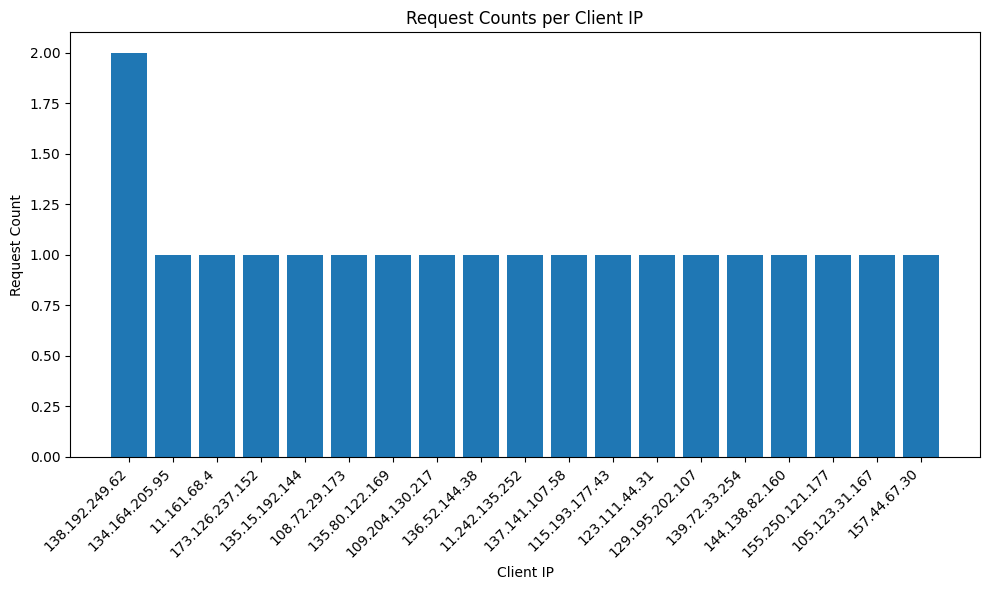

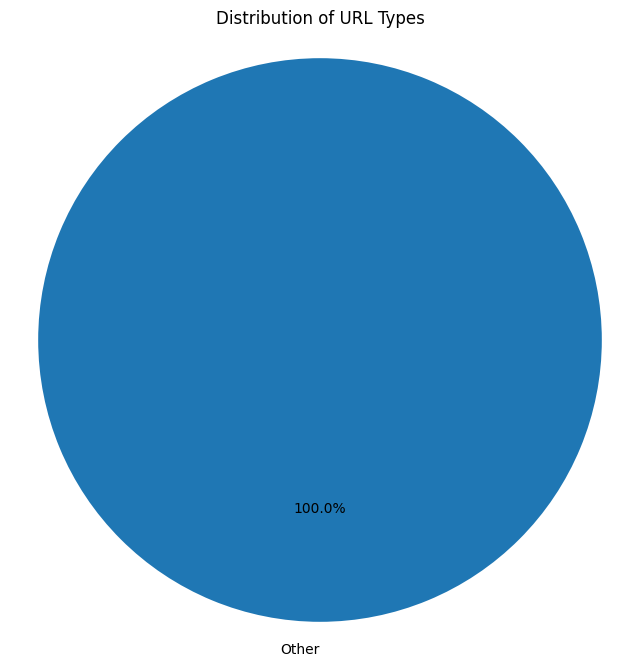

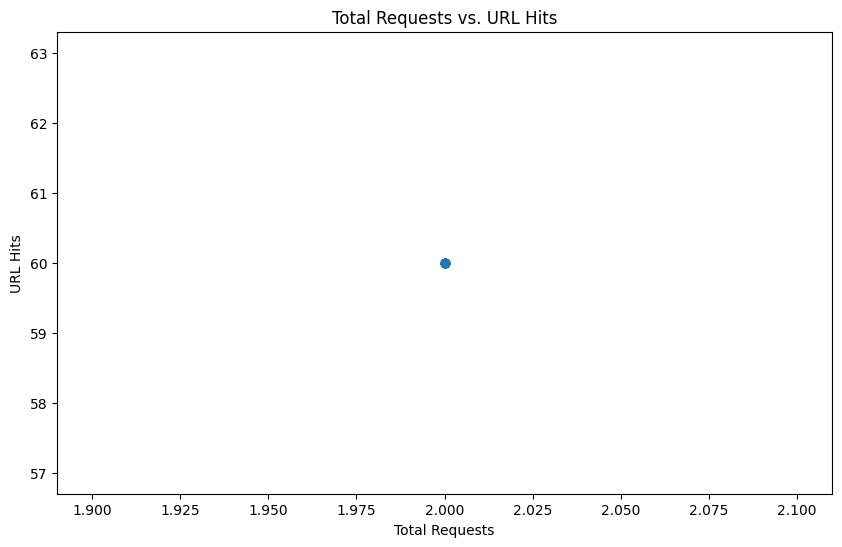

In [ ]:


import matplotlib.pyplot as plt


#  1: Bar chart of request counts per IP
ip_counts = optimized_df.groupBy("Client_IP").count().orderBy("count", ascending=False).toPandas()
plt.figure(figsize=(10, 6))
plt.bar(ip_counts["Client_IP"], ip_counts["count"])
plt.xlabel("Client IP")
plt.ylabel("Request Count")
plt.title("Request Counts per Client IP")
plt.xticks(rotation=45, ha="right")  # Rotate x-axis labels for readability
plt.tight_layout()
plt.show()

#  2: Pie chart of URL types
url_type_counts = optimized_df.groupBy("URL_Type").count().orderBy("count", ascending=False).toPandas()
plt.figure(figsize=(8, 8))
plt.pie(url_type_counts["count"], labels=url_type_counts["URL_Type"], autopct="%1.1f%%", startangle=90)
plt.title("Distribution of URL Types")
plt.axis("equal")  # Equal aspect ratio ensures that the pie chart is circular
plt.show()

#  3: Scatter plot of total requests vs. URL hits
plt.figure(figsize=(10, 6))
plt.scatter(optimized_df.select("TotalRequests").toPandas(), optimized_df.select("URL_Hits").toPandas())
plt.xlabel("Total Requests")
plt.ylabel("URL Hits")
plt.title("Total Requests vs. URL Hits")
plt.show()


In [ ]:
from pyspark.sql.functions import col, count, when, sum as sql_sum, avg as sql_avg

# This code analyzes web server logs to count total requests, image requests, and document requests per HTTP method. It uses PySpark DataFrame operations to group data, apply conditional counts, and calculate averages. The results are then displayed, showing HTTP method usage and associated URL patterns.

request_analysis_df = log_dataframe.groupBy("Request_Method").agg(
    count("*").alias("total_requests"),
    sql_sum(when(col("Requested_URL").like("%/images/%"), 1).otherwise(0)).alias("image_request_count"),
    sql_sum(when(col("Requested_URL").like("%/docs/%"), 1).otherwise(0)).alias("document_request_count"),
    sql_avg(when(col("Requested_URL").like("%/images/%"), 1).otherwise(0)).alias("average_image_request"),
    sql_avg(when(col("Requested_URL").like("%/docs/%"), 1).otherwise(0)).alias("average_document_request")
).orderBy(col("total_requests").desc())

request_analysis_df.show()

+--------------+--------------+-------------------+----------------------+---------------------+------------------------+
|Request_Method|total_requests|image_request_count|document_request_count|average_image_request|average_document_request|
+--------------+--------------+-------------------+----------------------+---------------------+------------------------+
|           GET|        667609|              66266|                     0|  0.09925869783061643|                     0.0|
|          POST|        666715|              66454|                     0|  0.09967377365141027|                     0.0|
|           PUT|        666328|              66412|                     0|  0.09966863166488577|                     0.0|
+--------------+--------------+-------------------+----------------------+---------------------+------------------------+



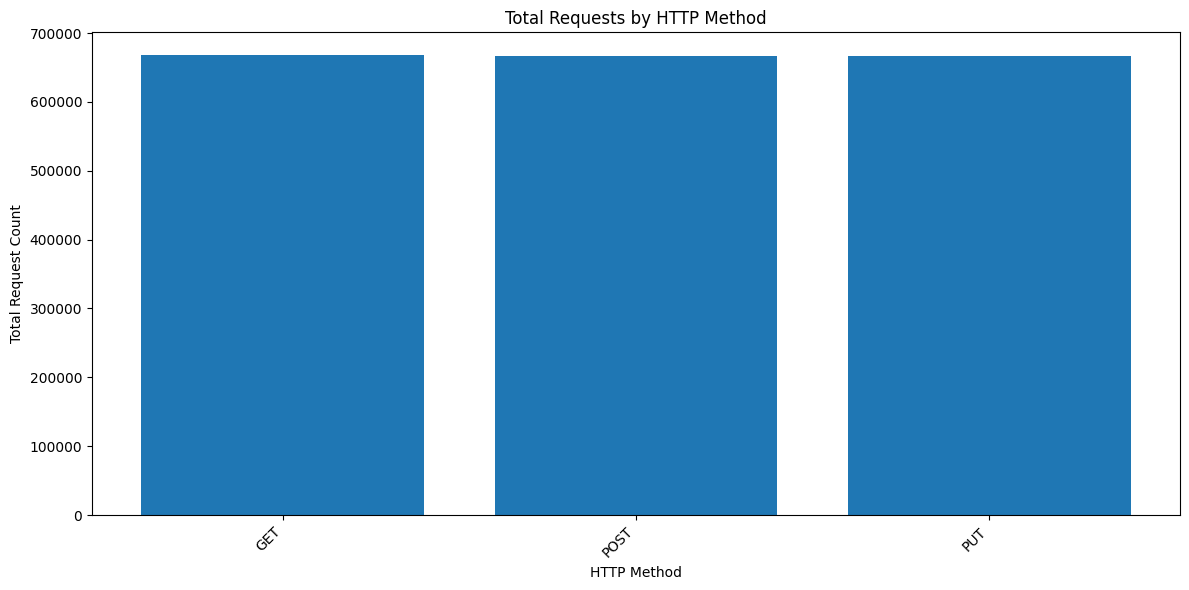

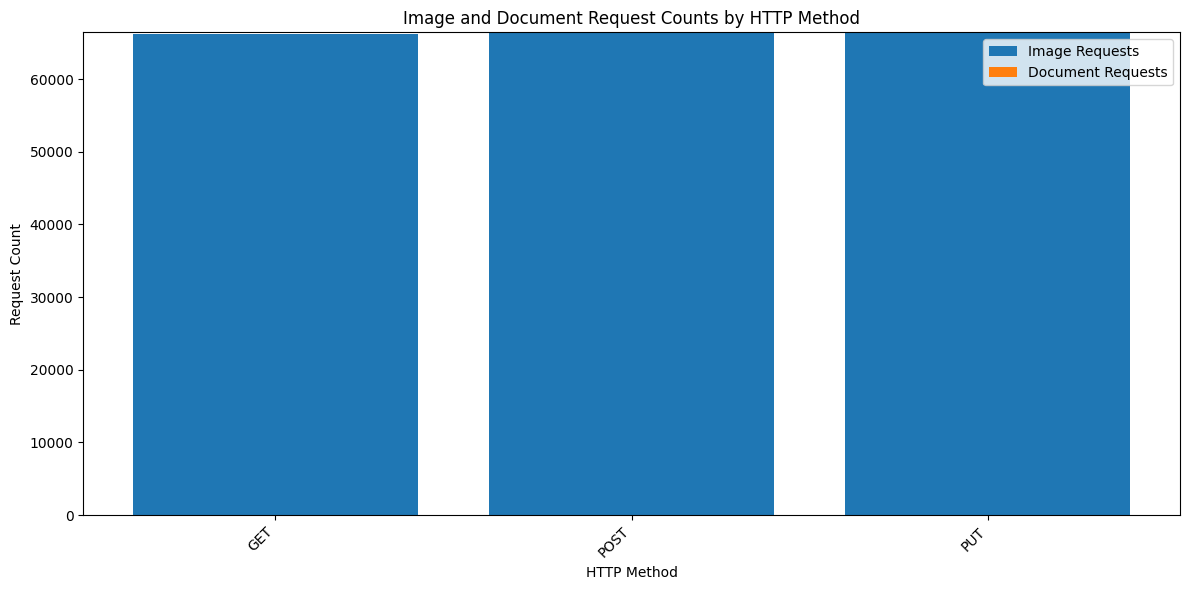

In [ ]:
# Convert Spark DataFrame to pandas DataFrame for plotting
pandas_df = request_analysis_df.toPandas()

# --- Visualization 1: Bar chart of HTTP Methods vs. Total Count ---
plt.figure(figsize=(12, 6))
plt.bar(pandas_df['Request_Method'], pandas_df['total_requests'])
plt.xlabel("HTTP Method")
plt.ylabel("Total Request Count")
plt.title("Total Requests by HTTP Method")
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
plt.tight_layout()
plt.show()

# --- Visualization 2: Stacked bar chart for Image and Document Counts ---
plt.figure(figsize=(12, 6))
plt.bar(pandas_df['Request_Method'], pandas_df['image_request_count'], label='Image Requests')
plt.bar(pandas_df['Request_Method'], pandas_df['document_request_count'], bottom=pandas_df['image_request_count'], label='Document Requests')
plt.xlabel("HTTP Method")
plt.ylabel("Request Count")
plt.title("Image and Document Request Counts by HTTP Method")
plt.xticks(rotation=45, ha='right')
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
def take_first_1000(iterator):
    count = 0
    for item in iterator:
        if count < 1000:
            yield item
            count += 1
        else:
            break

processed_logs_sample = processed_logs.mapPartitions(take_first_1000)

# Task 2

In [ ]:
#Top 10 most frequent IP addresses and their request methods (using only 1000 records)
top_ips_rdd = processed_logs_sample.map(lambda x: (x[0], 1)).reduceByKey(lambda a, b: a + b).takeOrdered(20, key=lambda x: -x[1])

print("Top 20 most frequent IP addresses:")
for ip, count in top_ips_rdd:
    print(f"IP: {ip}, Count: {count}")


Top 20 most frequent IP addresses:
IP: 123.31.25.147, Count: 1
IP: 87.51.27.172, Count: 1
IP: 20.172.131.244, Count: 1
IP: 248.182.198.107, Count: 1
IP: 161.11.231.16, Count: 1
IP: 58.25.132.254, Count: 1
IP: 143.167.226.151, Count: 1
IP: 2.197.95.99, Count: 1
IP: 198.160.85.94, Count: 1
IP: 237.70.96.214, Count: 1
IP: 226.201.125.225, Count: 1
IP: 176.31.213.152, Count: 1
IP: 204.173.68.5, Count: 1
IP: 27.168.218.97, Count: 1
IP: 123.228.201.138, Count: 1
IP: 24.106.148.57, Count: 1
IP: 115.212.216.228, Count: 1
IP: 173.140.155.59, Count: 1
IP: 209.4.97.104, Count: 1
IP: 80.48.131.4, Count: 1


In [ ]:

# Complex_RDD_Query 1:  Count of requests per HTTP_method (using only 1000 records)

method_counts = processed_logs_sample.map(lambda x: (x[1], 1)).reduceByKey(lambda a, b: a + b).collect()

print("\nRequest counts per HTTP method:")
for method, count in method_counts:
    print(f"Method: {method}, Count: {count}")


Request counts per HTTP method:
Method: POST, Count: 4337
Method: GET, Count: 4404
Method: PUT, Count: 4259


In [ ]:

from pyspark.sql.functions import desc

top_urls_per_method = processed_logs_sample.map(lambda x: (x[1], x[2])) \
    .groupByKey() \
    .mapValues(lambda urls: sorted(list(urls), key=list(urls).count, reverse=True)[:5]) \
    .collect()

print("Top 5 URLs per HTTP Method:")
for method, urls in top_urls_per_method:
    print(f"Method: {method}")
    for url in urls:
        print(f"  - {url}")

Top 5 URLs per HTTP Method:
Method: POST
  - /cloud-computing/apollo-11/
  - /cloud-computing/apollo-11/
  - /cloud-computing/apollo-11/
  - /cloud-computing/apollo-11/
  - /cloud-computing/apollo-11/
Method: GET
  - /cloud-computing/cybersecurity/
  - /cloud-computing/cybersecurity/
  - /cloud-computing/cybersecurity/
  - /images/apollo-11/
  - /cloud-computing/cybersecurity/
Method: PUT
  - /data-analysis/countdown/
  - /software/apollo/
  - /software/apollo/
  - /data-analysis/countdown/
  - /data-analysis/countdown/


In [ ]:

# Complex_RDD_Query 2: Calculate the average length of request_URLs for each IP address.
avg_url_length_per_ip = processed_logs_sample.map(lambda x: (x[0], len(x[2]))) \
    .groupByKey() \
    .mapValues(lambda lengths: sum(lengths) / len(lengths) if len(lengths) > 0 else 0) \
    .collect()

print("\nAvg URL_Length per IP_Address:")
for ip, avg_length in avg_url_length_per_ip:
    print(f"IP: {ip}, Average URL_Length: {avg_length}")





Avg URL_Length per IP_Address:
IP: 123.31.25.147, Average URL_Length: 24.0
IP: 87.51.27.172, Average URL_Length: 19.0
IP: 20.172.131.244, Average URL_Length: 39.0
IP: 248.182.198.107, Average URL_Length: 26.0
IP: 161.11.231.16, Average URL_Length: 32.0
IP: 58.25.132.254, Average URL_Length: 25.0
IP: 143.167.226.151, Average URL_Length: 20.0
IP: 2.197.95.99, Average URL_Length: 24.0
IP: 198.160.85.94, Average URL_Length: 22.0
IP: 237.70.96.214, Average URL_Length: 41.0
IP: 226.201.125.225, Average URL_Length: 19.0
IP: 176.31.213.152, Average URL_Length: 19.0
IP: 204.173.68.5, Average URL_Length: 15.0
IP: 27.168.218.97, Average URL_Length: 19.0
IP: 123.228.201.138, Average URL_Length: 17.0
IP: 24.106.148.57, Average URL_Length: 23.0
IP: 115.212.216.228, Average URL_Length: 22.0
IP: 173.140.155.59, Average URL_Length: 18.0
IP: 209.4.97.104, Average URL_Length: 32.0
IP: 80.48.131.4, Average URL_Length: 31.0
IP: 89.166.245.135, Average URL_Length: 21.0
IP: 131.196.174.127, Average URL_Leng

# Task 3

In [ ]:

# Optimization: Caching the processed_logs RDD
processed_logs.cache()

# Different Partition Strategies
#  1: Default Partitioning (no explicit partitioning)
default_partitions = processed_logs.getNumPartitions()
print(f"Number of partitions (default): {default_partitions}")


#  2: Custom Partitioning (hash partitioning by IP)
# Hash partitioning distributes data based on the hash value of a key, which can lead to better data locality
custom_partitioned_rdd = processed_logs.partitionBy(8, lambda x: hash(x[0]) if x else 0) # Assuming x[0] is IP
custom_partitions = custom_partitioned_rdd.getNumPartitions()
print(f"Number of partitions (custom): {custom_partitions}")

# Caching vs. No Caching
# Measuring execution time for a task without and with caching:
import time

# Without caching
start_time = time.time()

# Perform some analysis on the RDD
count = processed_logs.count()
print(f"Count (without caching): {count}")

end_time = time.time()
print(f"Execution time (without caching): {end_time - start_time} seconds")


# With caching (already cached)

start_time = time.time()
# Perform the same analysis on the cached RDD
count_cached = processed_logs.count()
print(f"Count (with caching): {count_cached}")

end_time = time.time()
print(f"Execution time (with caching): {end_time - start_time} seconds")


Number of partitions (default): 13
Number of partitions (custom): 8
Count (without caching): 2000652
Execution time (without caching): 35.1608772277832 seconds
Count (with caching): 2000652
Execution time (with caching): 5.244091510772705 seconds


# student 2: Narayanabhatla Sivarama Krishna Chaitanya  - 2769751

In [ ]:
import re

# This code parses web server logs, extracting client address, request type, response code, and payload size. It uses regex to match log entries, converts payload size to integer, and filters out invalid entries. Finally, it prints the first 10 parsed log entries with new column names.
log_data = spark.sparkContext.textFile(log_file)

def extract_log_details_s2(log_entry):
    """
    Function to extract client address, request type, response code, and payload size from a log entry.
    """
    try:
        pattern = r'(\d{1,3}\.\d{1,3}\.\d{1,3}\.\d{1,3}) - - .*?"(GET|POST|PUT|DELETE|HEAD|OPTIONS) .*?" (\d{3}) (\d+|-)'
        extracted_info = re.search(pattern, log_entry)
        if extracted_info:
            client_address = extracted_info.group(1)
            request_type = extracted_info.group(2)
            response_code = int(extracted_info.group(3))
            payload_size = extracted_info.group(4)
            payload_size = int(payload_size) if payload_size != '-' else 0
            return client_address, request_type, response_code, payload_size
    except Exception:
        return None

# Transform RDD with extracted information
parsed_rdd_s2 = log_data.map(extract_log_details_s2).filter(lambda entry: entry is not None)

# Display sample extracted records
print("Parsed Entries for Student 2:")
print("Client Address\tRequest Type\tResponse Code\tPayload Size")  # Header line
for entry in parsed_rdd_s2.take(10):
    print(entry[0] + "\t" + entry[1] + "\t" + str(entry[2]) + "\t" + str(entry[3]))

Parsed Entries for Student 2:
Client Address	Request Type	Response Code	Payload Size
88.211.105.115	POST	414	12456
144.6.49.142	POST	203	97126
231.70.64.145	PUT	201	33093
219.42.234.172	POST	415	68827
183.173.185.94	GET	205	30374
164.12.8.113	GET	200	14633
110.98.7.240	PUT	204	63819
27.182.196.243	GET	414	93885
123.31.25.147	GET	204	75897
220.182.78.75	GET	200	84446


In [ ]:
from pyspark.sql import Row, SparkSession
import re

In [ ]:
from pyspark.sql import Row
from pyspark.sql.functions import avg, col, count, desc


# Convert parsed_rdd_s2 to a DataFrame
request_logs_df = parsed_rdd_s2.map(lambda x: Row(
    client_ip=x[0],
    request_type=x[1],
    http_status=x[2],
    payload_bytes=x[3]
)).toDF()

# Register the DataFrame as a temporary view
request_logs_df.createOrReplaceTempView("web_request_logs")

In [ ]:



# This code analyzes web server logs to identify response time patterns based on IP addresses and HTTP methods. It categorizes response codes, calculates average response times and request counts, then ranks and filters results to show the top 5 slowest requests for each IP. The output displays the top 20 combinations, ordered by average response time and request count.

sql_query = """
WITH RequestResponseTimes AS (
    SELECT
        client_ip,
        request_type,
        payload_bytes AS response_time,
        http_status
    FROM web_request_logs
),
AverageResponseTimesByIPMethod AS (
    SELECT
        client_ip,
        request_type,
        AVG(response_time) AS avg_response_time,
        COUNT(*) AS request_count,
        CASE
            WHEN http_status >= 200 AND http_status < 300 THEN 'Success'
            WHEN http_status >= 300 AND http_status < 400 THEN 'Redirection'
            WHEN http_status >= 400 AND http_status < 500 THEN 'Client Error'
            WHEN http_status >= 500 THEN 'Server Error'
            ELSE 'Unknown'
        END AS status_category
    FROM RequestResponseTimes
    GROUP BY client_ip, request_type, http_status
),
RankedResponseTimes AS (
  SELECT
      client_ip,
      request_type,
      avg_response_time,
      request_count,
      status_category,
      RANK() OVER (PARTITION BY client_ip ORDER BY avg_response_time DESC) as response_rank
  FROM AverageResponseTimesByIPMethod
)
SELECT
    client_ip,
    request_type,
    avg_response_time,
    request_count,
    status_category
FROM RankedResponseTimes
WHERE response_rank <= 5
ORDER BY avg_response_time DESC, request_count DESC
LIMIT 20
"""

# Execute the query
response_times_df = spark.sql(sql_query)

# Display results
response_times_df.show()

+---------------+------------+-----------------+-------------+---------------+
|      client_ip|request_type|avg_response_time|request_count|status_category|
+---------------+------------+-----------------+-------------+---------------+
| 134.176.218.44|         PUT|         100000.0|            1|    Redirection|
| 16.173.232.129|         PUT|         100000.0|            1|   Client Error|
|  160.19.204.16|         PUT|         100000.0|            1|   Client Error|
| 168.76.244.166|         PUT|         100000.0|            1|   Server Error|
|128.193.174.143|         PUT|         100000.0|            1|        Success|
|  101.25.106.91|         GET|         100000.0|            1|        Success|
| 153.213.185.82|        POST|         100000.0|            1|        Success|
| 136.102.56.217|         PUT|         100000.0|            1|        Success|
| 192.183.95.185|         PUT|         100000.0|            1|   Client Error|
|  141.204.32.75|        POST|         100000.0|    

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
# Convert Spark DataFrame to Pandas DataFrame
pandas_df = response_times_df.toPandas()



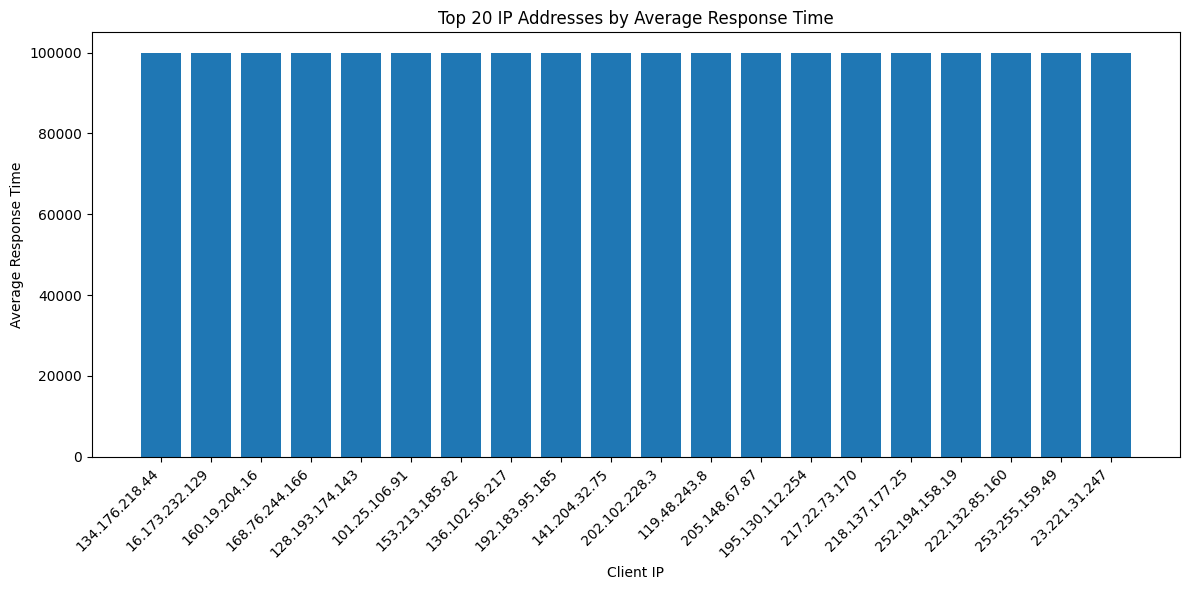

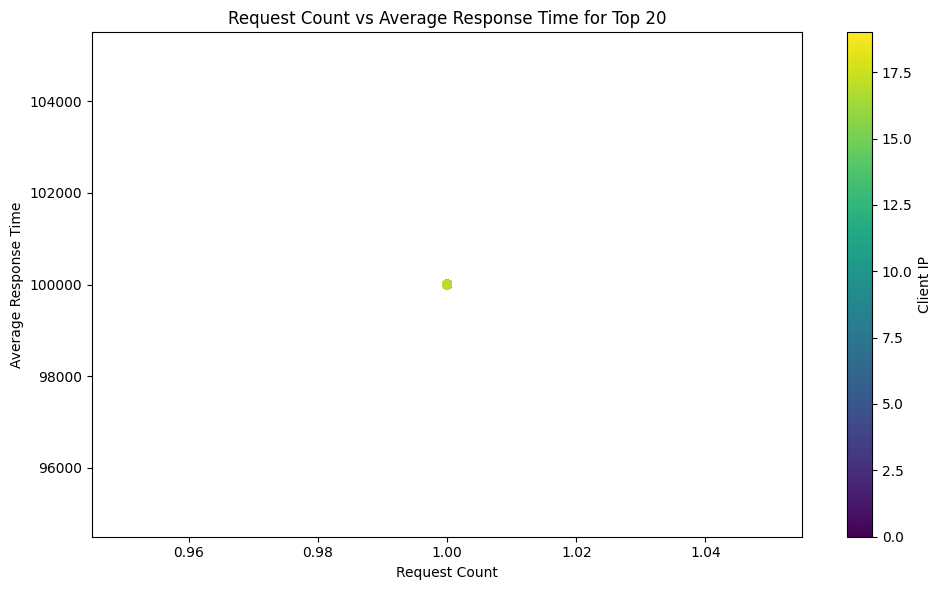

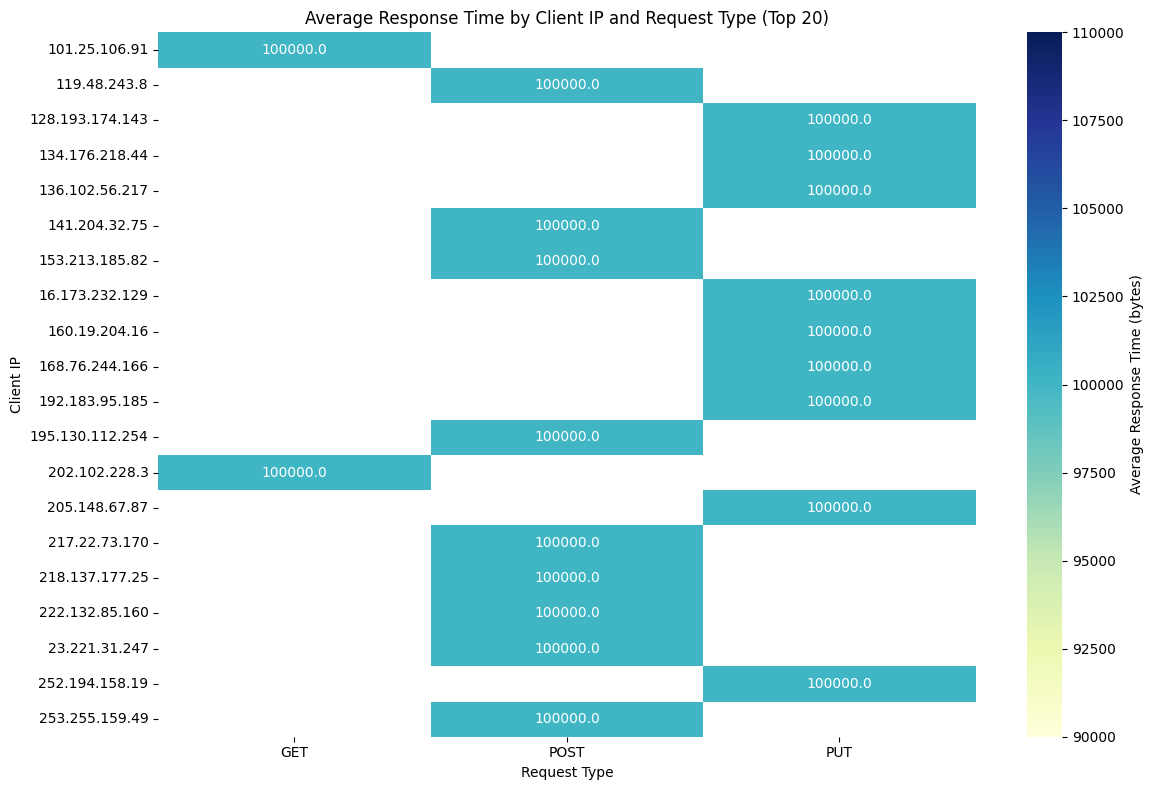

In [ ]:
# Visualization 1: Bar chart of Average Response Time per IP
plt.figure(figsize=(12, 6))
plt.bar(pandas_df['client_ip'], pandas_df['avg_response_time'])
plt.xlabel("Client IP")
plt.ylabel("Average Response Time")
plt.title("Top 20 IP Addresses by Average Response Time")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

# Visualization 2: Scatter plot of Request Count vs. Average Response Time
plt.figure(figsize=(10, 6))
plt.scatter(pandas_df['request_count'], pandas_df['avg_response_time'], c=pandas_df['client_ip'].astype('category').cat.codes, cmap='viridis')
plt.xlabel("Request Count")
plt.ylabel("Average Response Time")
plt.title("Request Count vs Average Response Time for Top 20")
plt.colorbar(label='Client IP')
plt.tight_layout()
plt.show()

# Visualization 3: Heatmap of IP Address vs. Request Type with Average Response Time
plt.figure(figsize=(12, 8))
heatmap_data = pandas_df.pivot_table(index="client_ip", columns="request_type", values="avg_response_time", aggfunc='sum') # Use pivot_table
sns.heatmap(heatmap_data, annot=True, cmap="YlGnBu", fmt=".1f", cbar_kws={'label': 'Average Response Time (bytes)'})
plt.title("Average Response Time by Client IP and Request Type (Top 20)")
plt.xlabel("Request Type")
plt.ylabel("Client IP")
plt.tight_layout()
plt.show()

In [ ]:
#  SQL query to analyze average response times per IP and HTTP method
sql_query = """
SELECT
    client_ip,
    request_type,
    AVG(payload_bytes) AS avg_response_time,
    COUNT(*) AS request_count
FROM web_request_logs
GROUP BY client_ip, request_type
ORDER BY avg_response_time DESC
LIMIT 20
"""

# Execute the query
response_times_df = spark.sql(sql_query)

# Display results
response_times_df.show()

+---------------+------------+-----------------+-------------+
|      client_ip|request_type|avg_response_time|request_count|
+---------------+------------+-----------------+-------------+
|  101.25.106.91|         GET|         100000.0|            1|
| 192.183.95.185|         PUT|         100000.0|            1|
| 136.102.56.217|         PUT|         100000.0|            1|
|    31.77.66.24|         GET|         100000.0|            1|
|  141.204.32.75|        POST|         100000.0|            1|
|195.130.112.254|        POST|         100000.0|            1|
| 153.213.185.82|        POST|         100000.0|            1|
|128.193.174.143|         PUT|         100000.0|            1|
| 16.173.232.129|         PUT|         100000.0|            1|
| 134.176.218.44|         PUT|         100000.0|            1|
| 168.76.244.166|         PUT|         100000.0|            1|
|  160.19.204.16|         PUT|         100000.0|            1|
|  202.102.228.3|         GET|         100000.0|       

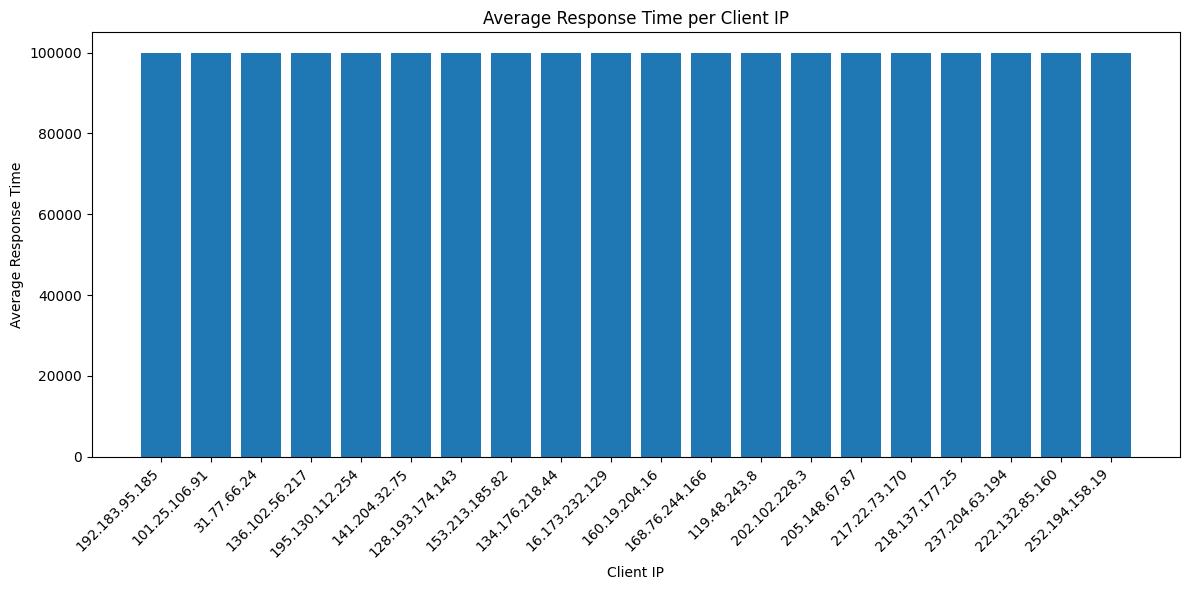

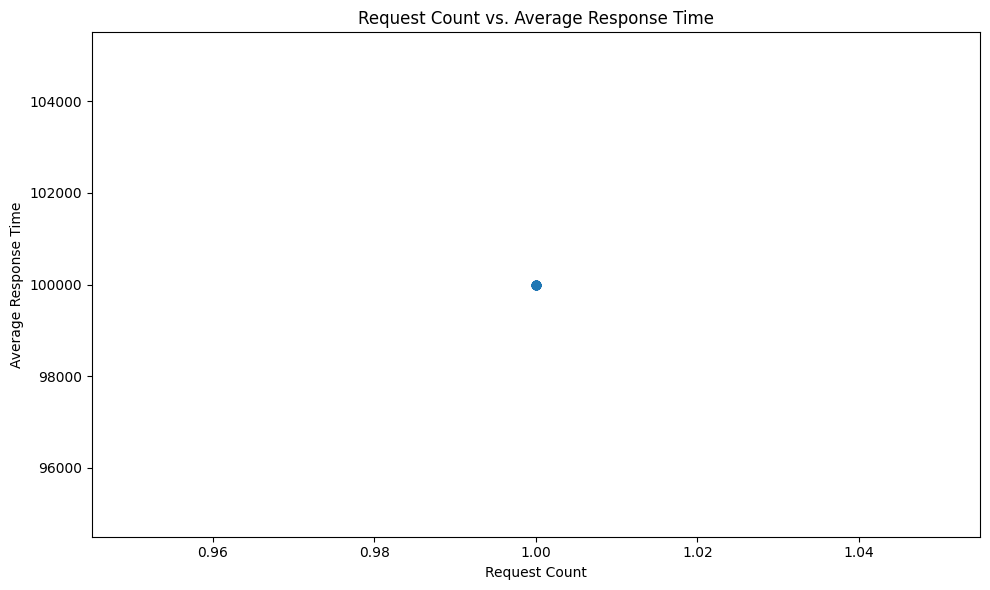

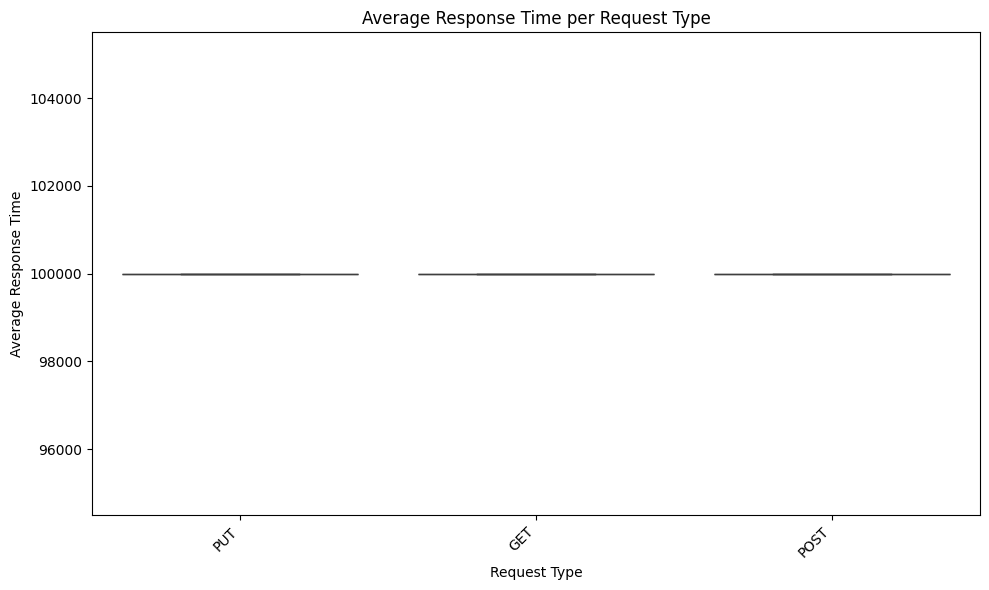

In [ ]:


import matplotlib.pyplot as plt
# Convert Spark DataFrame to Pandas DataFrame
pandas_df = response_times_df.toPandas()

# Visualization 1: Bar chart of Average Response Time per IP
plt.figure(figsize=(12, 6))
plt.bar(pandas_df['client_ip'], pandas_df['avg_response_time'])
plt.xlabel("Client IP")
plt.ylabel("Average Response Time")
plt.title("Average Response Time per Client IP")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

# Visualization 2: Scatter plot of Request Count vs. Average Response Time
plt.figure(figsize=(10, 6))
plt.scatter(pandas_df['request_count'], pandas_df['avg_response_time'])
plt.xlabel("Request Count")
plt.ylabel("Average Response Time")
plt.title("Request Count vs. Average Response Time")
plt.tight_layout()
plt.show()

# Visualization 3: Box plot of Average Response Time per Request Type
plt.figure(figsize=(10, 6))
sns.boxplot(x='request_type', y='avg_response_time', data=pandas_df)
plt.xlabel("Request Type")
plt.ylabel("Average Response Time")
plt.title("Average Response Time per Request Type")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()


In [ ]:


parsed_rdd_s2_sample = parsed_rdd_s2.take(1000)

# Task 2

In [ ]:
# 1st RDD Query: Count of requests per HTTP method (using only 1000 records)
method_counts = {}
for entry in parsed_rdd_s2_sample:
    method = entry[1]
    method_counts[method] = method_counts.get(method, 0) + 1

print("\nRequest counts per HTTP method (first 1000 records):")
for method, count in method_counts.items():
    print(f"Method: {method}, Count: {count}")


Request counts per HTTP method (first 1000 records):
Method: POST, Count: 313
Method: PUT, Count: 355
Method: GET, Count: 332


In [ ]:

# 2nd Complex RDD Query: Calculate the average payload size for each client IP.
ip_payload_sums = {}
ip_request_counts = {}
for entry in parsed_rdd_s2_sample:
    ip = entry[0]
    payload_size = entry[3]
    ip_payload_sums[ip] = ip_payload_sums.get(ip, 0) + payload_size
    ip_request_counts[ip] = ip_request_counts.get(ip, 0) + 1

avg_payload_per_ip = {}
for ip in ip_payload_sums:
    avg_payload_per_ip[ip] = ip_payload_sums[ip] / ip_request_counts[ip]

print("\nAverage Payload Size per IP Address (first 1000 records):")
for ip, avg_payload in avg_payload_per_ip.items():
    print(f"IP: {ip}, Average Payload Size: {avg_payload}")


Average Payload Size per IP Address (first 1000 records):
IP: 88.211.105.115, Average Payload Size: 12456.0
IP: 144.6.49.142, Average Payload Size: 97126.0
IP: 231.70.64.145, Average Payload Size: 33093.0
IP: 219.42.234.172, Average Payload Size: 68827.0
IP: 183.173.185.94, Average Payload Size: 30374.0
IP: 164.12.8.113, Average Payload Size: 14633.0
IP: 110.98.7.240, Average Payload Size: 63819.0
IP: 27.182.196.243, Average Payload Size: 93885.0
IP: 123.31.25.147, Average Payload Size: 75897.0
IP: 220.182.78.75, Average Payload Size: 84446.0
IP: 206.186.128.82, Average Payload Size: 24520.0
IP: 143.238.50.180, Average Payload Size: 31361.0
IP: 12.33.251.59, Average Payload Size: 37029.0
IP: 39.107.109.242, Average Payload Size: 68708.0
IP: 250.231.144.68, Average Payload Size: 69887.0
IP: 103.105.160.60, Average Payload Size: 3924.0
IP: 246.167.148.159, Average Payload Size: 1685.0
IP: 185.221.50.185, Average Payload Size: 22650.0
IP: 144.143.171.58, Average Payload Size: 49029.0
IP:

In [ ]:


# 3rd Complex RDD Query: Top 5 most frequent client IPs
ip_counts = {}
for entry in parsed_rdd_s2_sample:
    ip = entry[0]
    ip_counts[ip] = ip_counts.get(ip, 0) + 1

sorted_ip_counts = sorted(ip_counts.items(), key=lambda x: x[1], reverse=True)
top_5_ips = sorted_ip_counts[:5]

print("\nTop 5 most frequent Client IPs (first 1000 records):")
for ip, count in top_5_ips:
    print(f"IP: {ip}, Count: {count}")



Top 5 most frequent Client IPs (first 1000 records):
IP: 88.211.105.115, Count: 1
IP: 144.6.49.142, Count: 1
IP: 231.70.64.145, Count: 1
IP: 219.42.234.172, Count: 1
IP: 183.173.185.94, Count: 1


# Task 3

In [ ]:

parsed_rdd_s2.cache()


#  Partition Strategies
#  1: Default Partitioning (no explicit partitioning)
default_partitions = parsed_rdd_s2.getNumPartitions()
print(f"Number of partitions (default): {default_partitions}")


#  2: Custom Partitioning (hash partitioning by IP)
# Hash partitioning distributes data based on the hash value of a key, which can lead to better data locality
custom_partitioned_rdd = parsed_rdd_s2.partitionBy(8, lambda x: hash(x[0]) if x else 0)
custom_partitions = custom_partitioned_rdd.getNumPartitions()
print(f"Number of partitions (custom): {custom_partitions}")


# Caching vs. No Caching
# Measuring execution time for a task without and with caching:

# Without caching  (Unpersist to demonstrate)
parsed_rdd_s2.unpersist()

start_time = time.time()

# Perform some analysis on the RDD (e.g., count)
# Replace this with a more complex operation for better measurement
count = parsed_rdd_s2.count()
print(f"Count (without caching): {count}")

end_time = time.time()
print(f"Execution time (without caching): {end_time - start_time} seconds")

# With caching

start_time = time.time()
# Perform the same analysis on the cached RDD
count_cached = parsed_rdd_s2.count()
print(f"Count (with caching): {count_cached}")

end_time = time.time()
print(f"Execution time (with caching): {end_time - start_time} seconds")


Number of partitions (default): 13
Number of partitions (custom): 8
Count (without caching): 3000000
Execution time (without caching): 18.160755395889282 seconds
Count (with caching): 3000000
Execution time (with caching): 17.988293647766113 seconds


# student 3: Sanjay Kumar Gone - 2774272

In [ ]:
import re
from pyspark.sql import SparkSession

# Create a SparkSession
spark_session = SparkSession.builder.appName("LogAnalysis").getOrCreate()

# Path to your log file in Google Drive
log_file_path = "/content/drive/My Drive/web.log"

# Read the log file as text
log_data_rdd = spark_session.sparkContext.textFile(log_file_path)

In [ ]:
import re

def parse_log_entry_s3(log_entry):
    """
    Extracts timestamp, endpoint, and HTTP status code from a log entry.
    """
    try:
        # Updated regex to extract date-time, URL path, and response code
        pattern = r'\[(.*?)\] "\w+ (.*?) HTTP/.*?" (\d{3})'
        match = re.search(pattern, log_entry)

        if match:
            timestamp = match.group(1)  # Extracted timestamp
            endpoint = match.group(2) if match.group(2) else "N/A"  # Extracted request path
            response_code = int(match.group(3))  # Extracted status code
            return timestamp, endpoint, response_code
        else:
            print(f"Skipping unrecognized format: {log_entry}")
            return None
    except Exception as e:
        print(f"Error processing entry: {log_entry}, Issue: {e}")
        return None

# Apply parsing function and filter out invalid records
filtered_rdd_s3 = log_rdd.map(parse_log_entry_s3).filter(lambda record: record is not None)


# Display first 10 parsed log entries
print("Extracted Log Data for Analysis:")
print("Timestamp\t\tRequested URL\t\tStatus Code")
for log in filtered_rdd_s3.take(10):
    print(f"{log[0]}\t{log[1]}\t{log[2]}")


Extracted Log Data for Analysis:
Timestamp		Requested URL		Status Code
04/Mar/2022:14:17:48	/history/missions/	414
19/Jul/2022:01:31:31	/web-development/countdown/	201
08/Feb/2022:11:34:57	/networking/technology/	415
29/Aug/2023:03:07:11	/security/firewall/	205
22/May/2023:09:48:25	/web-development/technology/	200
22/Jan/2023:09:55:54	/history/apollo/	204
25/Feb/2023:12:03:32	/data-analysis/missions/	204
22/Dec/2022:12:55:00	/history/launch/	200
13/Oct/2023:07:21:13	/security/apollo-11/	404
15/Aug/2022:15:59:37	/web-development/data/	203


In [ ]:
from pyspark.sql import Row

# Transform the parsed RDD into a DataFrame
log_entry_df = filtered_rdd_s3.map(lambda record: Row(
    Event_Time=record[0],
    Resource_Path=record[1],
    Response_Code=record[2]
)).toDF()

# Register the DataFrame as a temporary SQL view
log_entry_df.createOrReplaceTempView("log_data_student_3")

In [ ]:
# The query analyzes web server logs to identify the top 5 most recent requests for each status code category (Success, Redirection, Client Error, Server Error, Unknown). It first uses a CTE called RequestPathStatus to select the timestamp, request path, and status code, categorizing the status codes into different groups. Another CTE, TopRequestPaths, assigns a rank to each request within each category based on the timestamp. Finally, the main query selects the top 5 ranked requests for each category from TopRequestPaths, ordering them by category and then by timestamp in descending order, providing insights into recent request patterns and potential issues.
sql_query_updated = """
WITH RequestAnalysis AS (
    SELECT
        Event_Time,
        Resource_Path,
        Response_Code,
        CASE
            WHEN Response_Code >= 200 AND Response_Code < 300 THEN 'Success'
            WHEN Response_Code >= 300 AND Response_Code < 400 THEN 'Redirection'
            WHEN Response_Code >= 400 AND Response_Code < 500 THEN 'Client Error'
            WHEN Response_Code >= 500 THEN 'Server Error'
            ELSE 'Unknown'
        END AS ResponseCategory
    FROM
        log_data_student_3
),
ResourceFrequency AS (
    SELECT
        Resource_Path,
        ResponseCategory,
        COUNT(*) AS HitCount
    FROM RequestAnalysis
    GROUP BY
        Resource_Path, ResponseCategory
)
SELECT
    'TopResources' AS AnalysisType,
    Resource_Path AS Details,
    ResponseCategory,
    HitCount AS MetricValue
FROM ResourceFrequency
ORDER BY MetricValue DESC
LIMIT 20

"""

request_path_df_s3_updated = spark.sql(sql_query_updated)
request_path_df_s3_updated.show()

+------------+--------------------+----------------+-----------+
|AnalysisType|             Details|ResponseCategory|MetricValue|
+------------+--------------------+----------------+-----------+
|TopResources|/data-analysis/te...|         Success|       7347|
|TopResources|     /software/data/|         Success|       7346|
|TopResources|/history/deep-lea...|         Success|       7340|
|TopResources|/security/technol...|         Success|       7336|
|TopResources|/data-analysis/ap...|         Success|       7331|
|TopResources|/software/technol...|         Success|       7326|
|TopResources|/security/deep-le...|         Success|       7312|
|TopResources|/cloud-computing/...|         Success|       7305|
|TopResources|/history/cybersec...|         Success|       7282|
|TopResources|/networking/apoll...|         Success|       7267|
|TopResources|/data-analysis/ap...|         Success|       7265|
|TopResources|/software/countdown/|         Success|       7260|
|TopResources|/web-develo

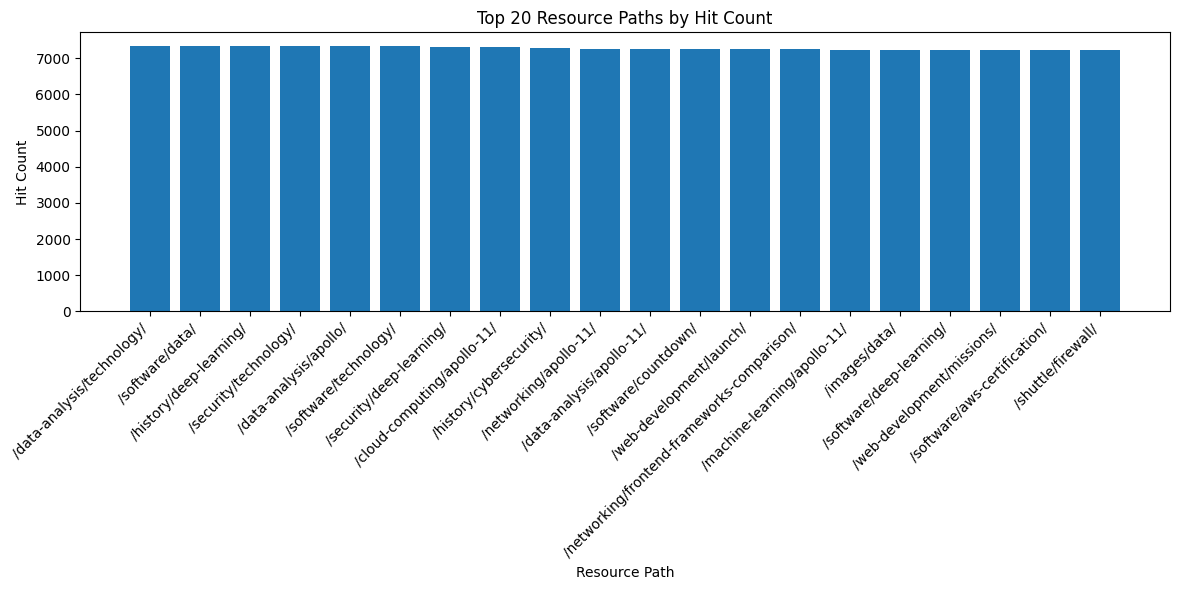

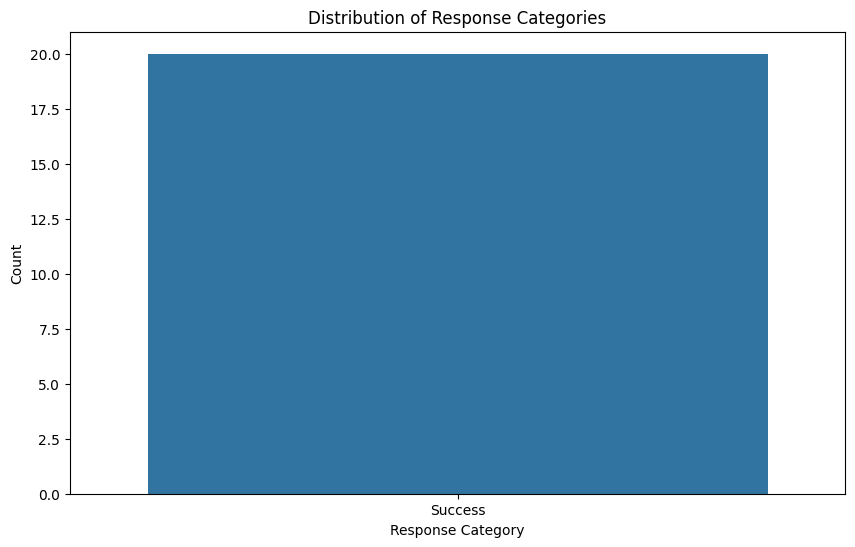

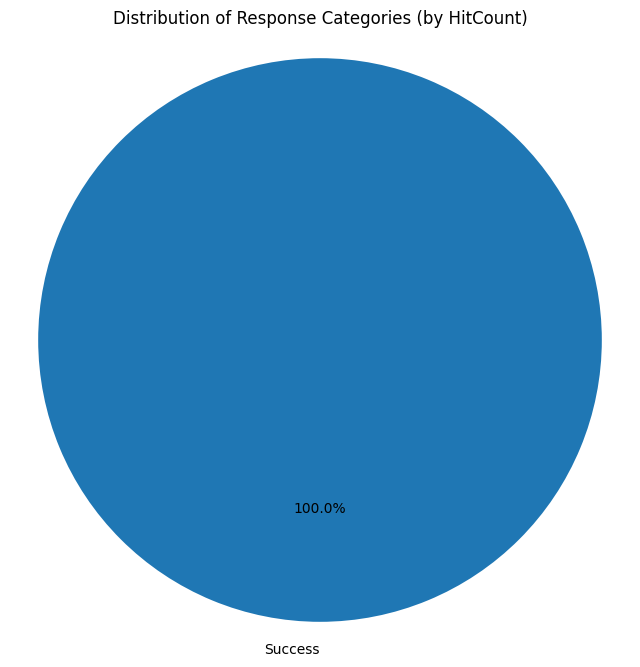

In [ ]:


import matplotlib.pyplot as plt


request_path_df_s3_updated = request_path_df_s3_updated.toPandas()

# Bar chart of HitCount for each Resource_Path
plt.figure(figsize=(12, 6))
plt.bar(request_path_df_s3_updated['Details'], request_path_df_s3_updated['MetricValue'])
plt.xlabel("Resource Path")
plt.ylabel("Hit Count")
plt.title("Top 20 Resource Paths by Hit Count")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

# Create a countplot using seaborn
plt.figure(figsize=(10, 6))
sns.countplot(x='ResponseCategory', data=request_path_df_s3_updated)
plt.xlabel("Response Category")
plt.ylabel("Count")
plt.title("Distribution of Response Categories")
plt.show()

# Pie chart of ResponseCategory
category_counts = request_path_df_s3_updated.groupby('ResponseCategory')['MetricValue'].sum()
plt.figure(figsize=(8, 8))
plt.pie(category_counts, labels=category_counts.index, autopct='%1.1f%%', startangle=90)
plt.title("Distribution of Response Categories (by HitCount)")
plt.axis('equal')
plt.show()


In [ ]:
# The query analyzes web server logs to identify the top 20 most frequent combinations of request paths and status codes. It uses a CTE called RequestPathStatusFrequency to group the log entries by request path and status code, calculating the frequency of each combination. Then, the main query selects the request path, status code, and frequency from this CTE, ordering the results in descending order of frequency and limiting the output to the top 20 combinations. This provides insights into the most common request patterns and their associated status codes, helping to understand website usage and potential areas of concern.
sql_query_2 = """
WITH HourlyRequests AS (
    SELECT
        DATE_FORMAT(Event_Time, 'yyyy-MM-dd HH:00:00') AS Hour,
        Resource_Path,
        COUNT(*) AS RequestCount
    FROM
        log_data_student_3
    GROUP BY
        Hour, Resource_Path
),
RankedRequests AS (
    SELECT
        Hour,
        Resource_Path,
        RequestCount,
        RANK() OVER (PARTITION BY Hour ORDER BY RequestCount DESC) as Rank
    FROM HourlyRequests
)
SELECT
    'HourlyTrafficAnalysis' AS AnalysisType,
    Hour as Details,
    Resource_Path,
    RequestCount AS MetricValue
FROM RankedRequests
WHERE Rank <= 3
ORDER BY Hour, MetricValue DESC
LIMIT 20;
"""

request_frequency_df = spark.sql(sql_query_2)
request_frequency_df.show()

+--------------------+-------+--------------------+-----------+
|        AnalysisType|Details|       Resource_Path|MetricValue|
+--------------------+-------+--------------------+-----------+
|HourlyTrafficAnal...|   NULL|     /software/data/|      16955|
|HourlyTrafficAnal...|   NULL|/web-development/...|      16946|
|HourlyTrafficAnal...|   NULL|/software/technol...|      16928|
+--------------------+-------+--------------------+-----------+



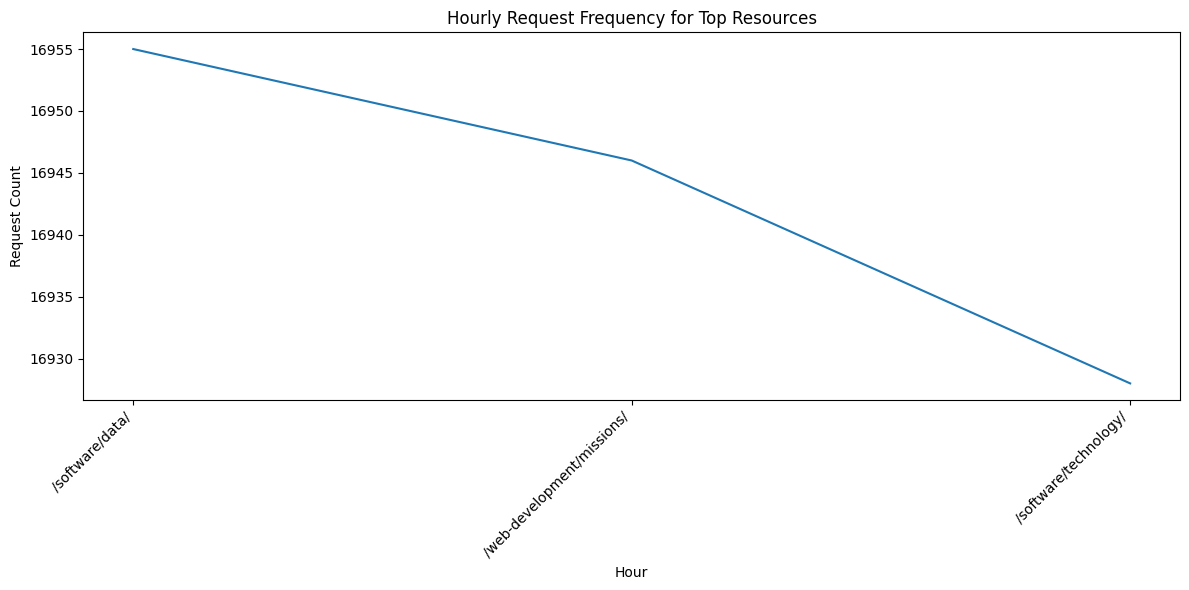

In [ ]:

import matplotlib.pyplot as plt

# Convert the Spark DataFrame to a Pandas DataFrame
request_frequency_pandas_df = request_frequency_df.toPandas()

# Create the plot
plt.figure(figsize=(12, 6))
plt.plot(request_frequency_pandas_df['Resource_Path'], request_frequency_pandas_df['MetricValue'])
plt.xlabel("Hour")
plt.ylabel("Request Count")
plt.title("Hourly Request Frequency for Top Resources")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()


# Task 2

In [ ]:

sample_rdd = filtered_rdd_s3.take(1000)

In [ ]:
# 1st RDD Query: Count of requests per status code
status_code_counts = {}
for entry in sample_rdd:
    status_code = entry[2]
    status_code_counts[status_code] = status_code_counts.get(status_code, 0) + 1

print("\nRequest counts per status code (first 1000 records):")
for status_code, count in status_code_counts.items():
    print(f"Status Code: {status_code}, Count: {count}")


Request counts per status code (first 1000 records):
Status Code: 414, Count: 46
Status Code: 201, Count: 71
Status Code: 415, Count: 82
Status Code: 205, Count: 79
Status Code: 200, Count: 65
Status Code: 204, Count: 84
Status Code: 404, Count: 67
Status Code: 203, Count: 68
Status Code: 416, Count: 81
Status Code: 500, Count: 67
Status Code: 308, Count: 68
Status Code: 304, Count: 78
Status Code: 307, Count: 72
Status Code: 202, Count: 72


In [ ]:
# 2nd Complex RDD Query:  Top 5 endpoints by request count
endpoint_counts = {}
for entry in sample_rdd:
    endpoint = entry[1]
    endpoint_counts[endpoint] = endpoint_counts.get(endpoint, 0) + 1

sorted_endpoint_counts = sorted(endpoint_counts.items(), key=lambda x: x[1], reverse=True)
top_5_endpoints = sorted_endpoint_counts[:5]

print("\nTop 5 endpoints by request count (first 1000 records):")
for endpoint, count in top_5_endpoints:
    print(f"Endpoint: {endpoint}, Count: {count}")


Top 5 endpoints by request count (first 1000 records):
Endpoint: /web-development/firewall/, Count: 15
Endpoint: /web-development/countdown/, Count: 14
Endpoint: /software/apollo/, Count: 14
Endpoint: /web-development/cybersecurity/, Count: 14
Endpoint: /cloud-computing/technology/, Count: 14


In [ ]:

# 3rd Complex RDD Query: Average status code for each endpoint
endpoint_status_sums = {}
endpoint_request_counts = {}

for entry in sample_rdd:
  endpoint = entry[1]
  status_code = entry[2]
  endpoint_status_sums[endpoint] = endpoint_status_sums.get(endpoint,0) + status_code
  endpoint_request_counts[endpoint] = endpoint_request_counts.get(endpoint, 0) + 1

avg_status_per_endpoint = {}
for endpoint in endpoint_status_sums:
  avg_status_per_endpoint[endpoint] = endpoint_status_sums[endpoint]/endpoint_request_counts[endpoint]

print("\nAverage status code per endpoint (first 1000 records):")
for endpoint, avg_status in avg_status_per_endpoint.items():
    print(f"Endpoint: {endpoint}, Average Status Code: {avg_status}")



Average status code per endpoint (first 1000 records):
Endpoint: /history/missions/, Average Status Code: 306.1666666666667
Endpoint: /web-development/countdown/, Average Status Code: 275.14285714285717
Endpoint: /networking/technology/, Average Status Code: 312.61538461538464
Endpoint: /security/firewall/, Average Status Code: 316.55555555555554
Endpoint: /web-development/technology/, Average Status Code: 267.46153846153845
Endpoint: /history/apollo/, Average Status Code: 290.8333333333333
Endpoint: /data-analysis/missions/, Average Status Code: 314.75
Endpoint: /history/launch/, Average Status Code: 255.41666666666666
Endpoint: /security/apollo-11/, Average Status Code: 334.57142857142856
Endpoint: /web-development/data/, Average Status Code: 202.0
Endpoint: /shuttle/cybersecurity/, Average Status Code: 343.8888888888889
Endpoint: /security/deep-learning/, Average Status Code: 346.2
Endpoint: /images/frontend-frameworks-comparison/, Average Status Code: 272.5
Endpoint: /software/apo

In [ ]:
import time

# Task 3

In [ ]:
# Optimization: Caching
start_time = time.time()
cached_rdd = filtered_rdd_s3.cache()
# Perform an action to trigger caching (e.g., count)
cached_count = cached_rdd.count()
end_time = time.time()
print(f"Time taken with caching: {end_time - start_time} seconds")

start_time = time.time()
# Perform the same action on the uncached RDD
uncached_count = filtered_rdd_s3.count()
end_time = time.time()
print(f"Time taken without caching: {end_time - start_time} seconds")




Time taken with caching: 75.62778663635254 seconds
Time taken without caching: 3.3897180557250977 seconds


In [ ]:


from pyspark.sql import SparkSession

spark_session = SparkSession.builder.appName("LogAnalysis").getOrCreate()

sample_data = [("192.168.1.1", "GET /index.html", 200),
              ("192.168.1.2", "POST /api/data", 201),
               ("192.168.1.1", "GET /about.html", 200),
                ("192.168.1.3", "GET /index.html", 404)]

sample_df = spark_session.createDataFrame(sample_data, ["client_ip", "request", "status_code"])

# Bucketing
bucketed_df = sample_df.write.bucketBy(4, "client_ip").sortBy("request").saveAsTable("bucketed_log_data")

# Read the bucketed data
bucketed_data = spark_session.table("bucketed_log_data")

# Analyze performance with and without bucketing
print("Bucketing complete.")
bucketed_data.show()


Bucketing complete.
+-----------+---------------+-----------+
|  client_ip|        request|status_code|
+-----------+---------------+-----------+
|192.168.1.1|GET /about.html|        200|
|192.168.1.1|GET /index.html|        200|
|192.168.1.3|GET /index.html|        404|
|192.168.1.2| POST /api/data|        201|
+-----------+---------------+-----------+



# student 4: Anil kumar Gangadhara - 2769112

In [ ]:

# Extract IP Address, Timestamp, URL, and Response Size
# Parse log entries to extract IP Address, Timestamp, URL, and Response Size.
# Handle missing or malformed response sizes gracefully.
log_rdd = spark.sparkContext.textFile(log_file)

def parse_log_s4(line):
    try:
        regex = r'(\d+\.\d+\.\d+\.\d+) - - \[(.*?)\] ".*? (.*?) HTTP/.*?" \d+ (\d+|-)'
        match = re.search(regex, line)
        if match:
            ip = match.group(1)
            timestamp = match.group(2)
            url = match.group(3)
            response_size = int(match.group(4)) if match.group(4) != '-' else 0
            return ip, timestamp, url, response_size
    except Exception as e:
        return None

parsed_rdd_s4 = log_rdd.map(parse_log_s4).filter(lambda x: x is not None)

In [ ]:
import re
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, to_timestamp, count, when, sum as sql_sum, avg as sql_avg
from pyspark.sql import Row
from pyspark.sql.functions import avg, col, count, desc
import matplotlib.pyplot as plt
import seaborn as sns

# Create a SparkSession
spark = SparkSession.builder.appName("LogAnalyzer").getOrCreate()

# Replace with the actual path to your log file
log_file = "/content/drive/My Drive/web.log"

# Log parsing function
def extract_log_data(log_entry):
    try:
        pattern = r'^(\S+) (\S+) (\S+) \[(.*?)\] "(.*?)" (\d+) (\d+|-)'
        match = re.match(pattern, log_entry)
        if match:
            ip_address = match.group(1)
            timestamp = match.group(4)
            request = match.group(5)
            status_code = int(match.group(6))
            response_size = int(match.group(7)) if match.group(7) != '-' else 0
            return ip_address, timestamp, request, status_code, response_size
        return None
    except Exception as e:
        return None

# Read and process the log file
log_rdd = spark.sparkContext.textFile(log_file)
parsed_logs = log_rdd.map(extract_log_data).filter(lambda x: x is not None)

# Convert to DataFrame
log_df = parsed_logs.toDF(["ip_address", "timestamp", "request", "status_code", "response_size"])





In [ ]:


from pyspark.sql.functions import col, to_timestamp, date_format

# Register the DataFrame as a temporary view
log_df.createOrReplaceTempView("web_log_data")
#The query identifies high-traffic hours by finding hours with more than 5 unique IP addresses making requests. It then selects detailed request information (IP, request, status, size, timestamp) for those high-traffic hours. The results are limited to the top 50 entries ordered by formatted timestamp for easier analysis
sql_query = """
WITH HourlyRequestCounts AS (
    SELECT
        date_format(to_timestamp(timestamp, 'dd/MMM/yyyy:HH:mm:ss'), 'yyyy-MM-dd HH:00:00') AS request_hour,
        ip_address,
        COUNT(*) AS request_count
    FROM web_log_data
    WHERE status_code >= 200 AND status_code < 300  -- Filter successful requests
    GROUP BY request_hour, ip_address
),
RankedHourlyRequests AS (
    SELECT
        request_hour,
        ip_address,
        request_count,
        RANK() OVER (PARTITION BY request_hour ORDER BY request_count DESC) as rank
    FROM HourlyRequestCounts
),
HighTrafficHours AS (
    SELECT request_hour
    FROM RankedHourlyRequests
    WHERE rank = 1
    GROUP BY request_hour
    HAVING COUNT(ip_address) > 5 --Consider hours with more than 5 unique IPs as high traffic
)
SELECT
    w.ip_address,
    w.request,
    w.status_code,
    w.response_size,
    date_format(to_timestamp(w.timestamp, 'dd/MMM/yyyy:HH:mm:ss'), 'yyyy-MM-dd HH:mm:ss') as formatted_timestamp
FROM web_log_data w
INNER JOIN HighTrafficHours h ON date_format(to_timestamp(w.timestamp, 'dd/MMM/yyyy:HH:mm:ss'), 'yyyy-MM-dd HH:00:00') = h.request_hour
ORDER BY formatted_timestamp
LIMIT 50;
"""

complex_analysis_df = spark.sql(sql_query)
complex_analysis_df.show()


+---------------+--------------------+-----------+-------------+-------------------+
|     ip_address|             request|status_code|response_size|formatted_timestamp|
+---------------+--------------------+-----------+-------------+-------------------+
|  148.31.136.47|PUT /machine-lear...|        203|        60819|2022-01-01 00:01:34|
| 125.35.103.142|POST /images/deep...|        414|        75833|2022-01-01 00:01:50|
| 226.82.251.219|GET /networking/a...|        200|        97160|2022-01-01 00:02:15|
|    202.60.12.4|POST /networking/...|        203|        14429|2022-01-01 00:02:30|
|  189.41.143.58|GET /web-developm...|        308|        35415|2022-01-01 00:02:45|
|124.120.101.157|POST /data-analys...|        415|         6328|2022-01-01 00:03:02|
|   247.13.67.64|POST /networking/...|        200|         5334|2022-01-01 00:03:07|
|  232.10.45.201|POST /web-develop...|        203|        65945|2022-01-01 00:04:02|
|  253.69.30.163|GET /data-analysi...|        205|         1745|2

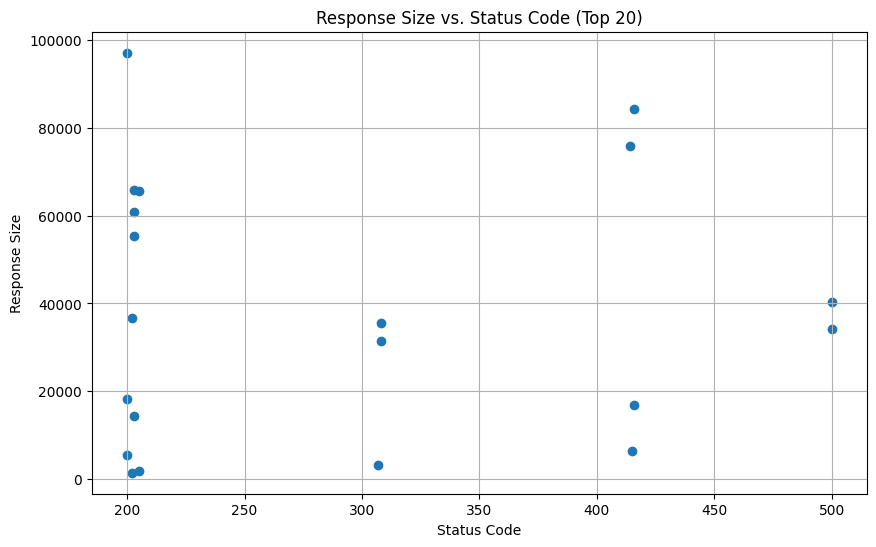

In [ ]:


import pandas as pd
import matplotlib.pyplot as plt

# Convert the Spark DataFrame to a Pandas DataFrame
pandas_df = complex_analysis_df.limit(20).toPandas()


# Response Size vs. Status Code
plt.figure(figsize=(10, 6))
plt.scatter(pandas_df['status_code'], pandas_df['response_size'])
plt.xlabel("Status Code")
plt.ylabel("Response Size")
plt.title("Response Size vs. Status Code (Top 20)")
plt.grid(True)
plt.show()


In [ ]:
from pyspark.sql.functions import window, sum as sql_sum

# Calculate the total response size for each IP address within a 5-minute window.
# Then, identify IP addresses with unusually high traffic (total response size > 1000000).
sql_query = """
WITH RequestStats AS (
    SELECT
        ip_address,
        COUNT(*) AS total_requests,
        SUM(CASE WHEN status_code >= 400 AND status_code < 600 THEN 1 ELSE 0 END) AS failed_requests,
        ROUND(
            (SUM(CASE WHEN status_code >= 400 AND status_code < 600 THEN 1 ELSE 0 END) * 100.0) / COUNT(*), 2
        ) AS error_rate
    FROM web_log_data
    GROUP BY ip_address
),
HighErrorIPs AS (
    SELECT ip_address
    FROM RequestStats
    WHERE error_rate > 50  -- Flag IPs with more than 50% failed requests
)
SELECT
    w.ip_address,
    w.timestamp,
    w.request,
    w.status_code,
    w.response_size
FROM web_log_data w
INNER JOIN HighErrorIPs h ON w.ip_address = h.ip_address
ORDER BY w.timestamp
LIMIT 50;

"""
high_traffic_ips_df = spark.sql(sql_query)
high_traffic_ips_df.show()

+---------------+--------------------+--------------------+-----------+-------------+
|     ip_address|           timestamp|             request|status_code|response_size|
+---------------+--------------------+--------------------+-----------+-------------+
| 183.235.94.245|01/Apr/2022:00:01:07|GET /networking/a...|        414|        39874|
|226.186.245.163|01/Apr/2022:00:02:50|PUT /security/dat...|        414|        75696|
|  75.82.160.152|01/Apr/2022:00:02:57|POST /shuttle/fro...|        500|        10191|
| 226.118.175.29|01/Apr/2022:00:03:57|POST /cloud-compu...|        416|        85531|
|    56.13.10.67|01/Apr/2022:00:03:58|POST /machine-lea...|        416|        71521|
| 214.114.187.73|01/Apr/2022:00:05:13|PUT /web-developm...|        414|        98762|
| 223.177.79.248|01/Apr/2022:00:07:16|GET /machine-lear...|        500|        17541|
|   191.98.205.7|01/Apr/2022:00:07:45|PUT /images/deep-...|        414|        84186|
|   84.99.187.96|01/Apr/2022:00:08:04|POST /web-develo

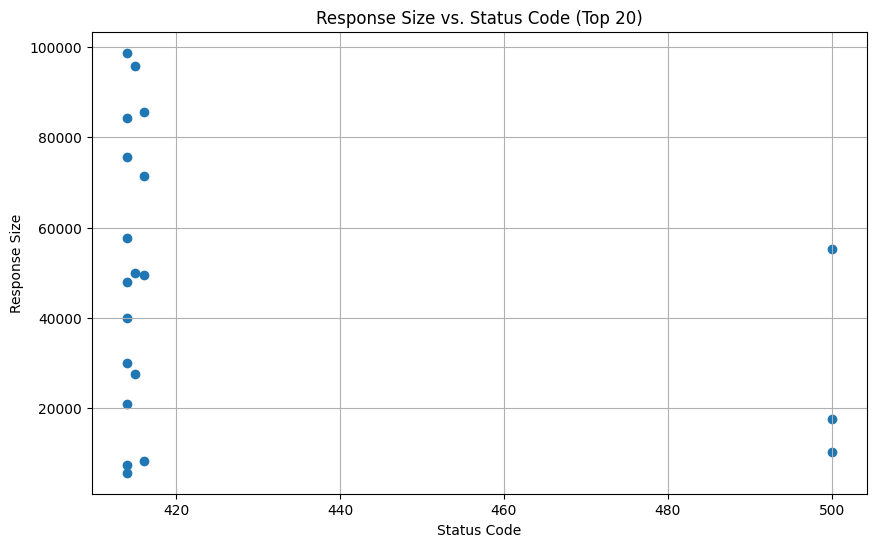

In [ ]:

import pandas as pd
import matplotlib.pyplot as plt

# Assuming high_traffic_ips_df is a Spark DataFrame
pandas_df = high_traffic_ips_df.limit(20).toPandas()

# Example plot:  Response Size vs. Status Code
plt.figure(figsize=(10, 6))
plt.scatter(pandas_df['status_code'], pandas_df['response_size'])
plt.xlabel("Status Code")
plt.ylabel("Response Size")
plt.title("Response Size vs. Status Code (Top 20)")
plt.grid(True)
plt.show()


# Task 2

In [ ]:


sample_rdd = parsed_logs.take(1000)

In [ ]:
# 1st RDD Query: Count of requests per status code
status_code_counts = {}
for entry in sample_rdd:
    status_code = entry[3]  # Assuming status code is at index 3
    status_code_counts[status_code] = status_code_counts.get(status_code, 0) + 1

print("\nRequest counts per status code (first 1000 records):")
for status_code, count in status_code_counts.items():
    print(f"Status Code: {status_code}, Count: {count}")


Request counts per status code (first 1000 records):
Status Code: 414, Count: 61
Status Code: 203, Count: 70
Status Code: 201, Count: 69
Status Code: 415, Count: 82
Status Code: 205, Count: 63
Status Code: 200, Count: 64
Status Code: 204, Count: 76
Status Code: 404, Count: 64
Status Code: 307, Count: 69
Status Code: 500, Count: 71
Status Code: 416, Count: 93
Status Code: 308, Count: 69
Status Code: 304, Count: 77
Status Code: 202, Count: 72


In [ ]:
# 2nd Complex RDD Query: Top 5 most frequent IP addresses
ip_counts = {}
for entry in sample_rdd:
    ip_address = entry[0]  # Assuming IP address is at index 0
    ip_counts[ip_address] = ip_counts.get(ip_address, 0) + 1

sorted_ip_counts = sorted(ip_counts.items(), key=lambda item: item[1], reverse=True)
top_5_ips = sorted_ip_counts[:5]

print("\nTop 5 most frequent IP addresses (first 1000 records):")
for ip, count in top_5_ips:
    print(f"IP Address: {ip}, Count: {count}")


Top 5 most frequent IP addresses (first 1000 records):
IP Address: 88.211.105.115, Count: 1
IP Address: 144.6.49.142, Count: 1
IP Address: 231.70.64.145, Count: 1
IP Address: 219.42.234.172, Count: 1
IP Address: 183.173.185.94, Count: 1


In [ ]:

# 3rd Complex RDD Query: Average response size for each status code
status_code_response_sums = {}
status_code_request_counts = {}

for entry in sample_rdd:
    status_code = entry[3]
    response_size = entry[4]
    status_code_response_sums[status_code] = status_code_response_sums.get(status_code, 0) + response_size
    status_code_request_counts[status_code] = status_code_request_counts.get(status_code, 0) + 1

avg_response_per_status = {}
for status_code in status_code_response_sums:
    avg_response_per_status[status_code] = status_code_response_sums[status_code] / status_code_request_counts[status_code]

print("\nAverage response size per status code (first 1000 records):")
for status_code, avg_response in avg_response_per_status.items():
    print(f"Status Code: {status_code}, Average Response Size: {avg_response}")



Average response size per status code (first 1000 records):
Status Code: 414, Average Response Size: 51282.475409836065
Status Code: 203, Average Response Size: 60168.47142857143
Status Code: 201, Average Response Size: 51911.02898550725
Status Code: 415, Average Response Size: 45032.28048780488
Status Code: 205, Average Response Size: 45092.857142857145
Status Code: 200, Average Response Size: 42081.0
Status Code: 204, Average Response Size: 56120.05263157895
Status Code: 404, Average Response Size: 51335.015625
Status Code: 307, Average Response Size: 49728.014492753624
Status Code: 500, Average Response Size: 48304.718309859156
Status Code: 416, Average Response Size: 52966.784946236556
Status Code: 308, Average Response Size: 47978.159420289856
Status Code: 304, Average Response Size: 52873.36363636364
Status Code: 202, Average Response Size: 45526.5


# Task 3

In [ ]:


# a. Different Partition Strategies
# Repartitioning

repartitioned_rdd = parsed_logs.repartition(4)
# Coalesce
coalesced_rdd = parsed_logs.coalesce(2)  # Reduces the number of partitions

# Evaluate Performance
# Time taken for a count operation
import time

start_time = time.time()
original_count = parsed_logs.count()
end_time = time.time()
print(f"Original RDD count: {original_count}, Time taken: {end_time - start_time} seconds")

start_time = time.time()
repartitioned_count = repartitioned_rdd.count()
end_time = time.time()
print(f"Repartitioned RDD count: {repartitioned_count}, Time taken: {end_time - start_time} seconds")

start_time = time.time()
coalesced_count = coalesced_rdd.count()
end_time = time.time()
print(f"Coalesced RDD count: {coalesced_count}, Time taken: {end_time - start_time} seconds")
# b. Caching vs. No Caching

# Operations to perform on the RDD
def my_operation(rdd):
    return rdd.map(lambda x: x[0]).distinct().count()

# Time the operations with caching
start_time_cached = time.time()
cached_rdd = filtered_rdd_s3.cache()
cached_result = my_operation(cached_rdd)
end_time_cached = time.time()
print(f"Cached RDD Operation Result: {cached_result} Time taken (with caching): {end_time_cached - start_time_cached} seconds")

# Time the operations without caching
start_time_uncached = time.time()
uncached_result = my_operation(filtered_rdd_s3)
end_time_uncached = time.time()
print(f"Uncached RDD Operation Result: {uncached_result} Time taken (without caching): {end_time_uncached - start_time_uncached} seconds")


Original RDD count: 3000000, Time taken: 25.987160682678223 seconds
Repartitioned RDD count: 3000000, Time taken: 41.6082546710968 seconds
Coalesced RDD count: 3000000, Time taken: 30.128341913223267 seconds
Cached RDD Operation Result: 1967309 Time taken (with caching): 15.161173582077026 seconds
Uncached RDD Operation Result: 1967309 Time taken (without caching): 15.822693347930908 seconds
